In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.interpolate import griddata
from tqdm import tqdm
from typing import Sequence, Optional

In [2]:
# Define the grid size for interpolation grid
# grid_size = 15000
grid_size = 1000

# paths to the .npy file
npy_folders_path = [r'.\data\SAC105',
	r'.\data\SAC305',
	r'.\data\Senju',
]

# path to the directory to save the images
image_folder_path = r'.\images'

In [3]:
# Define needed functions
def plot_xy_plane(
				X: Sequence[float], 
				Y: Sequence[float], 
				c: Optional[Sequence[float]] = None, 
				cmap: str = 'viridis', 
				x_label: str = 'X axis', 
				y_label: str = 'Y axis',
                colorbar_label: str = 'Color Intensity',
				title: str = 'XY Plane'
			) -> None:
    plt.figure(figsize=(8, 6))
    
    # Check if color data is provided
    if c is not None:
        plt.scatter(X, Y, c=c, cmap=cmap, s=10)  # Use color mapping
        plt.colorbar(label=colorbar_label)  # Add a colorbar
    else:
        plt.plot(X, Y, 'bo', markersize=3)  # Simple scatter plot
    
    # Set labels, title, and grid
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True)
    
    # Show the plot
    plt.show()

def plot_interpolated_grid(averaged_df: pd.DataFrame, interpolated_df: np.ndarray):
	# Plotting the Averaged data and interpolated data side by side
	fig, axes = plt.subplots(1, 2, figsize=(20, 10))
	
	# Get the min and max for setting the same scale
	x_min, x_max = averaged_df['X Location (µm)'].min(), averaged_df['X Location (µm)'].max()
	y_min, y_max = averaged_df['Y Location (µm)'].min(), averaged_df['Y Location (µm)'].max()
	nlcreq_min, nlcreq_max = averaged_df['NLCREQ (µm/µm)'].min(), averaged_df['NLCREQ (µm/µm)'].max()

	# Averaged data plot
	axes[0].scatter(averaged_df['X Location (µm)'], averaged_df['Y Location (µm)'],
								c=averaged_df['NLCREQ (µm/µm)'], cmap='viridis', vmin=nlcreq_min, vmax=nlcreq_max)
	axes[0].set_title('Averaged NLCREQ Data')
	axes[0].set_xticks([])
	axes[0].set_yticks([])
	axes[0].set_xlim(x_min, x_max)
	axes[0].set_ylim(y_min, y_max)

	# plot it
	img = axes[1].imshow(interpolated_df,
							extent=(x_min, x_max, y_min, y_max),
							origin='lower',
							aspect='auto',
							cmap='viridis', vmin=nlcreq_min, vmax=nlcreq_max)
	axes[1].set_title('Interpolated NLCREQ Data')
	axes[1].set_xticks([])
	axes[1].set_yticks([])
	# axes[1].invert_yaxis()  # Invert the y-axis

	# Add a colorbar to the right side of the plots
	fig.colorbar(img, ax=axes, orientation='vertical', fraction=0.02, pad=0.04, label='NLCREQ (µm/µm)')

	# Display the plots
	plt.show()

  0%|          | 0/7 [00:00<?, ?it/s]

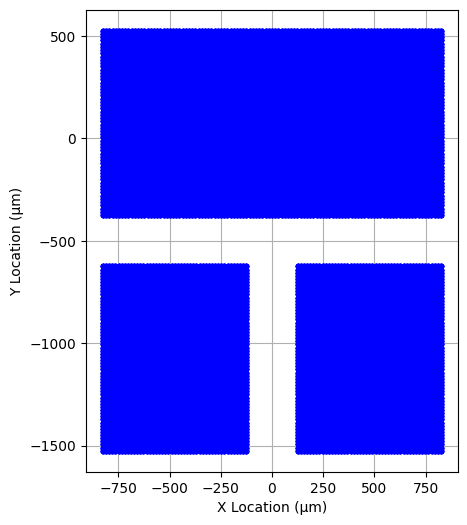

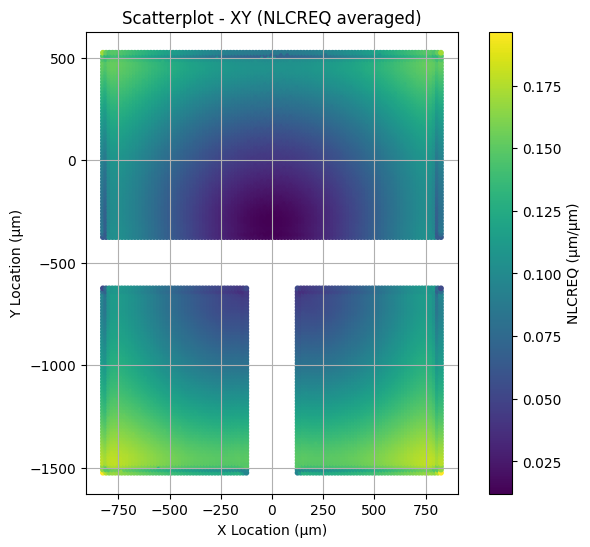

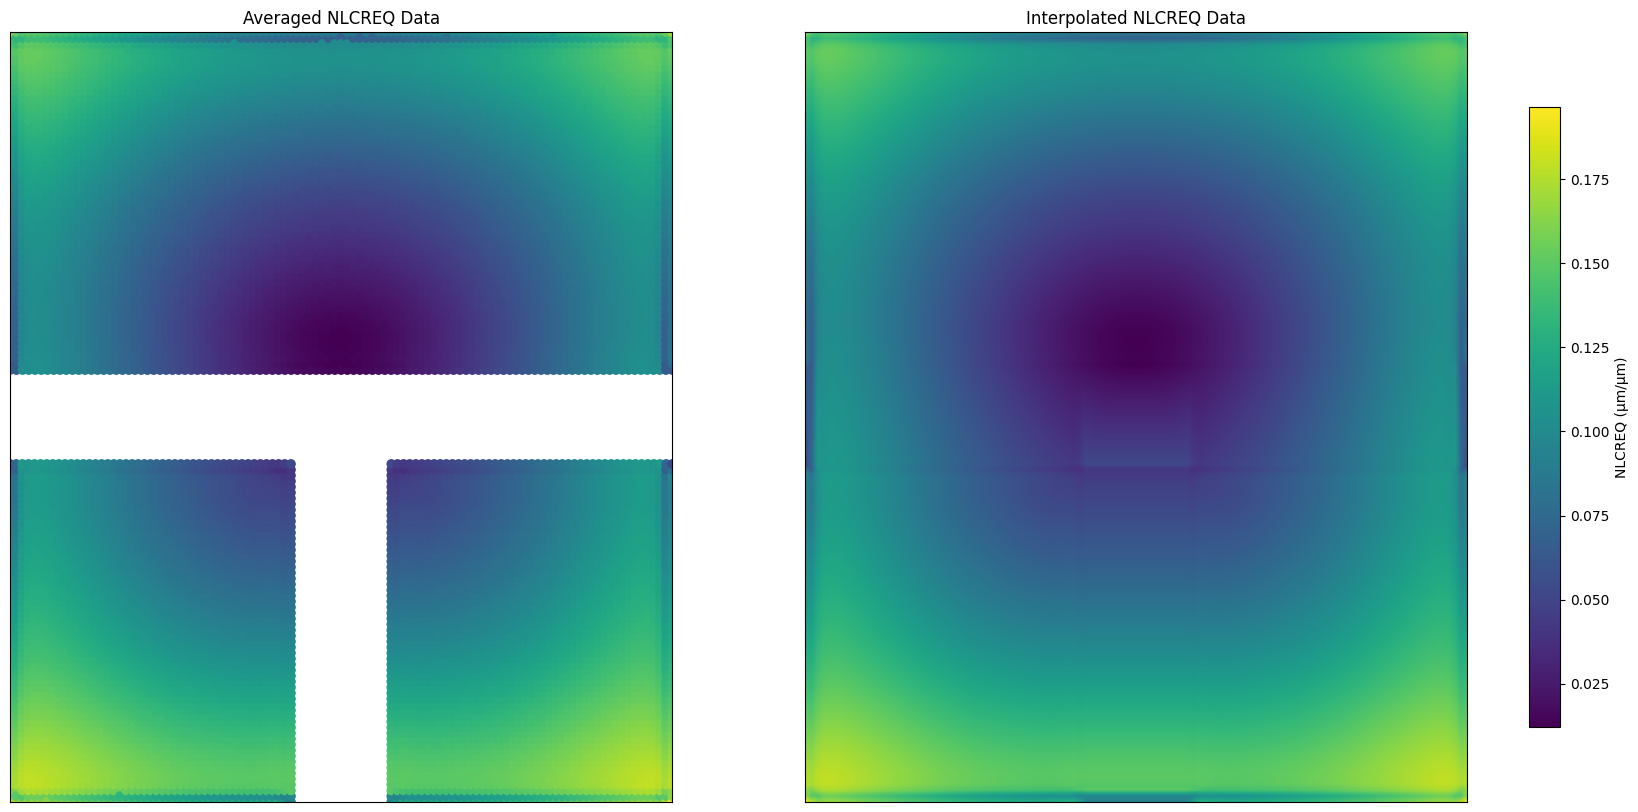

  0%|          | 0/7 [00:01<?, ?it/s]

Image saved: .\images\SAC105\grayscale_FCGB1_sac105_1000x1000.png


In [4]:
for npy_folder_path in npy_folders_path:
	# Create the directory if it doesn't exist to save the images
	os.makedirs(os.path.join(image_folder_path, os.path.basename(npy_folder_path)), exist_ok=True)

	# Get a list of all .npy files in the folder
	npy_files = [os.path.join(npy_folder_path, file) for file in os.listdir(npy_folder_path) if file.endswith('.npy')]


	for npy_file in tqdm(npy_files):
		# Create path to save the greyscale image
		greyscale_image_save_path = os.path.join(image_folder_path, os.path.basename(npy_folder_path), f'grayscale_{os.path.basename(npy_file)[:-4]}_{grid_size}x{grid_size}.png')



		# Load the data from .npy file
		try:
			arr = np.load(npy_file)
		except IOError as e:
			print("Failed to read the file:", npy_file)
			print("Error message:", str(e))
			break
		except Exception as e:
			print("An error occurred while reading the file:", npy_file)
			print("Error message:", str(e))
			break



		# Create dataframe from the loaded numpy array
		df = pd.DataFrame(arr, columns=['X Location (µm)', 'Y Location (µm)', 'Z Location (µm)', 'NLCREQ (µm/µm)'])
		plot_xy_plane(df['X Location (µm)'], df['Y Location (µm)'], x_label='X Location (µm)', y_label='Y Location (µm)', title=None)



		# Group by X and Y Location and calculate the mean of NLREQ and 
		grouped_data = df.groupby(['X Location (µm)', 'Y Location (µm)'])['NLCREQ (µm/µm)'].mean().reset_index()
		grouped_data['NLCREQ (µm/µm)'] = grouped_data['NLCREQ (µm/µm)'].round(4)  # round 'NLCREQ' values to 4 decimal places
		plot_xy_plane(grouped_data['X Location (µm)'], grouped_data['Y Location (µm)'],
					c=grouped_data['NLCREQ (µm/µm)'], x_label='X Location (µm)', y_label='Y Location (µm)', colorbar_label='NLCREQ (µm/µm)', title='Scatterplot - XY (NLCREQ averaged)')
		


		# Interpolated data plot
		# Define grid points based on the current file's data
		x_vals = np.linspace(grouped_data['X Location (µm)'].min(), grouped_data['X Location (µm)'].max(), grid_size)
		y_vals = np.linspace(grouped_data['Y Location (µm)'].min(), grouped_data['Y Location (µm)'].max(), grid_size)
		X, Y = np.meshgrid(x_vals, y_vals)

		# Interpolate NLCREQ values onto the grid
		NLCREQ_interp = griddata((grouped_data['X Location (µm)'], grouped_data['Y Location (µm)']),
								  grouped_data['NLCREQ (µm/µm)'], 
								  (X, Y), 
								  method='linear')
		plot_interpolated_grid(grouped_data, NLCREQ_interp)



		# Normalise NLCREQ dimension and save it as grayscale image of the interpolated data
		# handle nans in the interpolated array
		NLCREQ_interp = np.nan_to_num(NLCREQ_interp)

		# convert third dimension as grey scale
		normalized_max = np.max(NLCREQ_interp)
		if normalized_max == 0:
			normalized_img = np.zeros_like(NLCREQ_interp, dtype=np.uint8)
		else:
			normalized_img = (NLCREQ_interp / normalized_max * 255).astype(np.uint8)



		# save image using Matplotlib library
		plt.imsave(greyscale_image_save_path, normalized_img, cmap='grey', format='png', dpi=600, origin='lower')
		print(f"Image saved: {greyscale_image_save_path}")
		break
	break

In [5]:
type(grouped_data), type(NLCREQ_interp)

(pandas.core.frame.DataFrame, numpy.ndarray)

In [6]:
NLCREQ_interp.shape

(1000, 1000)